## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

In [1]:
import pandas as pd
import numpy as np

#load training dataset
df_train = pd.read_csv('train.csv', engine = 'python')
#load test dataset
df_test = pd.read_csv('test.csv', engine = 'python')
#set the features names
features_names = ['fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost']

In [2]:
#filter train dataset 
df_train = df_train[(df_train['compliance'] == 0) | (df_train['compliance'] == 1)]

#retrieve training datas
X = df_train[features_names]
y = df_train['compliance']

In [3]:
print('Non compliant {} \nCompliant {}'.format(len(df_train[df_train['compliance'] == 0]), 
                           len(df_train[df_train['compliance'] == 1])))

Non compliant 148283 
Compliant 11597


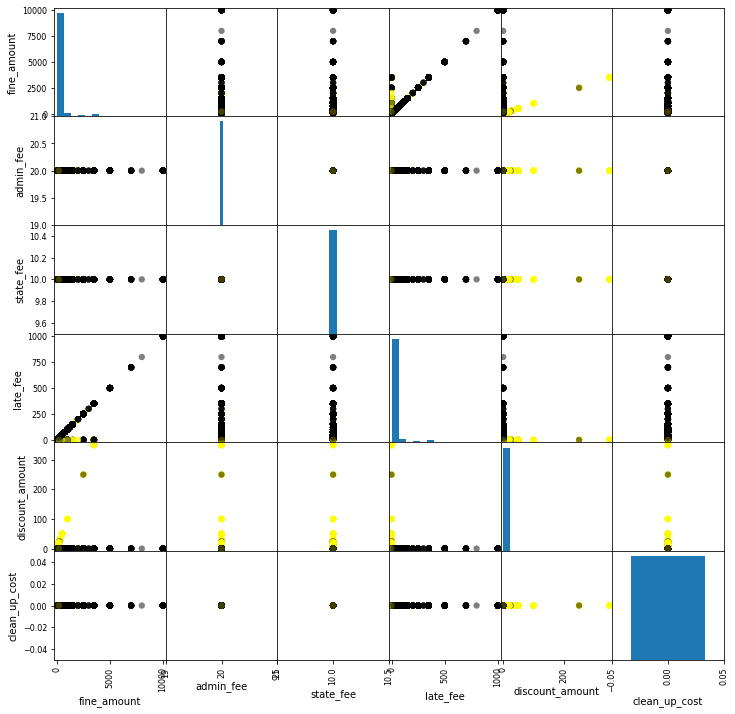

In [6]:
#plot the data (help to have an idea on how the features are correlated)
from matplotlib import cm
from pandas.plotting import scatter_matrix

cmap = cm.get_cmap('gnuplot')

scatter = scatter_matrix(X, c = y, marker = 'o', s = 40, 
                        hist_kwds = {'bins' : 15}, figsize = (12, 12), cmap = cmap);

In [7]:
from sklearn.model_selection import train_test_split

#split the train data in order to calculate the Area under the ROC curve
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

## K-nn classifier

In [8]:
#Using Knn classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

for this_n in [1, 5, 10, 100]:
    #initialize classifier
    knn = KNeighborsClassifier(n_neighbors = this_n)
    #train classifier
    knn.fit(X_train, y_train)
    #retrieve score from the test set
    y_score = knn.predict(X_test)
    #calculate false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_test, y_score)
    #calculate the roc_auc score
    roc_auc = auc(fpr, tpr)
    print('For {} neighbor(s) roc_auc = {}'.format(this_n, roc_auc))


For 1 neighbor(s) roc_auc = 0.5598523955741465
For 5 neighbor(s) roc_auc = 0.5535103859778387
For 10 neighbor(s) roc_auc = 0.5501089270370705
For 100 neighbor(s) roc_auc = 0.5461459252622617


## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
#initialize classifier
lr = LogisticRegression().fit(X_train, y_train)
y_score = lr.predict(X_test)
#calculate false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_score)
#calculate roc_auc score
roc_auc = auc(fpr, tpr)
print('roc_auc', roc_auc)

roc_auc 0.5411494026610717


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
lr = LogisticRegression().fit(X_train_scaled, y_train)
y_score = lr.predict(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print('roc_auc', roc_auc)

roc_auc 0.5050494557583628


## Support Vector Machine (slowwwwww)

In [12]:
'''from sklearn.svm import SVC, LinearSVC

for this_gamma in [0.01, 1, 5]:
    
    for this_C in [0.1, 1, 15, 250]:
        svm = SVC(gamma = this_gamma, C = this_C).fit(X_train, y_train)
        y_score = svm.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        print(auc(fpr, tpr))''';

In [13]:
from sklearn.metrics import confusion_matrix

In [16]:
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

dt = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 7, random_state = 0).fit(X_train, y_train)
y_score = dt.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
#retrieve the confusion matrix
conf_matrix = confusion_matrix(y_test, y_score)

'''df_cm = pd.DataFrame(conf_matrix)

plt.figure(figsize=(5.5, 4))
sns.heatmap(df_cm, annot = True)
plt.title('Decision tree \n')
plt.ylabel('True label')
plt.xlabel('Predicted label')'''
print('auc_roc ', auc(fpr, tpr))
print('confusion matrix', conf_matrix)

auc_roc  0.5502818177701272
confusion matrix [[37063    15]
 [ 2600   292]]


## Gradient Boosting (Giving better results)

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
#set tuning parameters
grid_params = {'random_state': [0], 'learning_rate': [0.4]}
gbc = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, random_state = 0).fit(X_train, y_train)
y_score = gbc.predict(X_test)
y_score = gbc.decision_function(X_test)

print('roc_auc_score = ', roc_auc_score(y_test, y_score))

roc_auc_score =  0.7536669920246631


In [25]:
from sklearn.model_selection import GridSearchCV
#second try with GradientBoosting
grid_params = {'random_state': [0], 'learning_rate': [0.4]}
clf = GradientBoostingClassifier(random_state = 0)
grid_cv = GridSearchCV(clf, param_grid = grid_params, scoring = 'roc_auc', cv = 5, n_jobs = 2)
grid_cv.fit(X_train, y_train) 
y_decision = grid_cv.decision_function(X_test)
print('roc_auc_score = ', roc_auc_score(y_test, y_decision))

roc_auc_score =  0.7548994411765649


In [26]:
#train the original data
grid_cv.fit(X, y)
#calculate the probability for predictions
y_prob = grid_cv.predict_proba(df_test[features_names])
#result to be returned
pd.Series(data = y_prob[:, 1], index = df_test['ticket_id'], name = 'compliance', dtype ='float32')

ticket_id
284932    0.060696
285362    0.023520
285361    0.069556
285338    0.060696
285346    0.069556
            ...   
376496    0.023520
376497    0.023520
376499    0.069556
376500    0.069556
369851    0.261442
Name: compliance, Length: 61001, dtype: float32